# Requirements

In [1]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import torch_geometric.utils.convert
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import category_encoders as ce
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 

# Data pre-processing

In [2]:
filename = "NF-ToN-IoT.csv"
dataPS = pd.read_csv(filename)

In [3]:
print("number of begnin connections: " + str(dataPS[dataPS['Label'] == 0].shape[0]))
print("number of maliciouse connections: " + str(dataPS[dataPS['Label'] == 1].shape[0]))

number of begnin connections: 270279
number of maliciouse connections: 1108995


In [4]:
data0 = dataPS[dataPS['Label'] == 0].sample(frac=1)
data1 = dataPS[dataPS['Label'] == 1].sample(frac=1)

In [5]:
data0_split = np.array_split(data0, 4)
data1_split = np.array_split(data1, 15)

# Statistical Comparisons of Classifiers with PAIRED T-TEST

chunk 0:  0.4
Precision: 0.9991
Recall: 0.9904
Accuracy: 0.9952
F1 Score: 0.9947
    
chunk 1:  0.4
Precision: 0.9837
Recall: 0.9931
Accuracy: 0.9872
F1 Score: 0.9884

chunk 2: 0.4
Precision: 0.9985
Recall: 0.9878
Accuracy: 0.9938
F1 Score: 0.9931

chunk 3: 0.6
Precision: 0.9894
Recall: 0.9997
Accuracy: 0.9951
F1 Score: 0.9946

chunk 4: 0.2
Precision: 0.9994
Recall: 0.9932
Accuracy: 0.9966
F1 Score: 0.9963

chunk 5: 0.2
Precision: 0.9994
Recall: 0.9922
Accuracy: 0.9962
F1 Score: 0.9958

chunk 6:
Precision: 0.9992
Recall: 0.9899
Accuracy: 0.9951
F1 Score: 0.9946

chunk 7, if a sample has a unce>30% put it in the malicious one:
Precision: 0.8993
Recall: 1.0000
Accuracy: 0.9494
F1 Score: 0.9470



In [6]:
chunk=6
nodes_percentages=0.4
dataPSA = pd.concat([data0_split[int(chunk/3)], data1_split[chunk]], ignore_index=True)

In [7]:

dataPSA['IPV4_SRC_ADDR'] = dataPSA.IPV4_SRC_ADDR.apply(str)
dataPSA['L4_SRC_PORT'] = dataPSA.L4_SRC_PORT.apply(str)
dataPSA['IPV4_DST_ADDR'] = dataPSA.IPV4_DST_ADDR.apply(str)
dataPSA['L4_DST_PORT'] = dataPSA.L4_DST_PORT.apply(str)

#dataPSA["id"]=dataPSA.index.tolist()
#dataPSA["id"]=dataPSA.id.apply(str)

dataPSA['IPV4_SRC'] = dataPSA['IPV4_SRC_ADDR'].apply(lambda x: int(x.split('.')[0]))##############
dataPSA['IPV4_DST'] = dataPSA['IPV4_DST_ADDR'].apply(lambda x: int(x.split('.')[0]))##############

dataPSA['IPV4_SRC_ADDR'] = dataPSA['IPV4_SRC_ADDR'] + ':' + dataPSA['L4_SRC_PORT'] # + ':' + dataPSA["id"]
dataPSA['IPV4_DST_ADDR'] = dataPSA['IPV4_DST_ADDR'] + ':' + dataPSA['L4_DST_PORT'] # + ':' + dataPSA["id"]
#dataPSA.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

dataPSA.rename(columns={"Label": "label"},inplace = True)
label=dataPSA.label

dataPSA.drop(columns=['Attack','label'],inplace = True)
#dataPSA.drop(columns=['id'],inplace = True)


cols_to_norm =  list(set(list(dataPSA.iloc[:,:].columns ))  - set(list(['label','IPV4_DST_ADDR','IPV4_SRC_ADDR',])) )
#cols_to_norm= list([ 'L4_SRC_PORT', 'L4_DST_PORT','PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS','TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS' ])
scaler = StandardScaler()
dataPSA[cols_to_norm] = scaler.fit_transform(dataPSA[cols_to_norm])

data=  dataPSA
data['x'] = data[ cols_to_norm ].values.tolist()
data['y']= label
#data = data.sample(frac=1)

In [8]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC,IPV4_DST,x,y
0,192.168.1.195:65011,1.431341,192.168.1.1:49152,1.269634,-0.393622,-0.791700,-0.009166,-0.010213,-0.007134,-0.007685,0.900240,-0.083907,0.093295,0.178983,"[-0.01021330677772264, 0.9002397054057473, 0.1...",0
1,192.168.1.180:55587,1.039192,192.168.1.190:53,-0.831729,2.324005,-0.834485,-0.009449,-0.013734,-0.007456,-0.008696,-1.995955,-0.083950,0.093295,0.178983,"[-0.013733961483097142, -1.9959551696038476, 0...",0
2,192.168.1.184:443,-1.255444,192.168.1.30:41500,0.942140,-0.393622,1.005248,-0.010181,-0.015712,-0.007778,-0.009707,-0.172425,-0.083744,0.093295,0.178983,"[-0.01571164268801579, -0.17242506311632488, 0...",0
3,192.168.1.152:80,-1.270549,192.168.1.31:39042,0.836941,-0.393622,-0.791700,-0.010181,-0.015960,-0.007778,-0.010212,-0.172425,-0.083950,0.093295,0.178983,"[-0.01596004709056596, -0.17242506311632488, 0...",0
4,192.168.1.190:34291,0.153029,208.84.2.53:53,-0.831729,2.324005,-0.834485,-0.010106,-0.015587,-0.007778,-0.009707,-1.995955,-0.083897,0.093295,0.613666,"[-0.015587440486740706, -1.9959551696038476, 0...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123015,192.168.1.35:35336,0.196513,192.168.1.190:80,-0.830574,-0.393622,-0.791700,-0.008770,-0.005264,-0.007134,-0.007179,0.900240,-0.083739,0.093295,0.178983,"[-0.005264326757684671, 0.9002397054057473, 0....",1
123016,192.168.1.36:47250,0.692275,52.59.177.21:80,-0.830574,-0.393622,-0.787893,-0.007974,0.045506,-0.006974,-0.003641,0.900240,-0.075893,0.093295,-3.624494,"[0.04550571151737667, 0.9002397054057473, -3.6...",1
123017,192.168.1.36:60096,1.226819,192.168.1.190:80,-0.830574,-0.393622,-0.791700,-0.008787,-0.005264,-0.007134,-0.007179,0.900240,-0.082511,0.093295,0.178983,"[-0.005264326757684671, 0.9002397054057473, 0....",1
123018,192.168.1.30:41636,0.458667,192.168.1.184:443,-0.815038,-0.393622,1.005248,-0.010008,-0.015673,-0.007617,-0.009707,-0.065159,-0.083950,0.093295,0.178983,"[-0.015673426626084994, -0.06515858626411766, ...",1


In [9]:
X_train=data
y_train=label

# Graph Construction

In [11]:
class CreateGraphStructures:
    def __init__(self, dataframe,subnet,inject_anomaly=False):
        self.data = dataframe  
        self.n_subnet = min(subnet,(len(dataframe)-1))     
        self.MG=nx.MultiGraph()    
        self.add_nodes()
        self.add_edges()
        if inject_anomaly:
            self.add_anomaly()
        self.MG=self.MG.to_directed()
        self.pyg_graph = torch_geometric.utils.convert.from_networkx(self.MG)
        self.g= torch_geometric.utils.to_networkx(self.pyg_graph)
        
    def get_pyg_graphh(self,):
        return self.pyg_graph        
        
    def get_NetworkX(self):
        return self.MG      
    
    def get_g(self):
        return self.g
    
    def add_anomaly(self):
        source_list = self.data['IPV4_SRC_ADDR'].to_list()
        destination_list = self.data['IPV4_DST_ADDR'].to_list()
        nodes_features = self.data['x'].to_list()
        labels = self.data['y'].to_list()
        index_list = self.data.index.to_list()
        
        for s1,d1, xr, yr, index1  in zip(source_list,destination_list,nodes_features,labels,index_list):
            comm= str(s1)+str('-')+str(d1)+str('-')+str(index1)
            self.MG.add_node(comm, x=xr*15, y = 1)
            break
    
    def add_nodes(self):
        i=0
        source_list = self.data['IPV4_SRC_ADDR'].to_list()
        destination_list = self.data['IPV4_DST_ADDR'].to_list()
        nodes_features = self.data['x'].to_list()
        labels = self.data['y'].to_list()
        index_list = self.data.index.to_list()
        
        for s1,d1, xr, yr, index1  in zip(source_list,destination_list,nodes_features,labels,index_list):
            i+=1
            b=str(i)+"/"+str(len(self.data))
            comm= str(s1)+str('-')+str(d1)+str('-')+str(index1)
            self.MG.add_node(comm, x=xr, y = yr) 
            
   
    def add_edges(self):
        i=0
        source_list = self.data['IPV4_SRC_ADDR'].to_list()
        destination_list = self.data['IPV4_DST_ADDR'].to_list()
        nodes_features = self.data['x'].to_list()
        labels = self.data['y'].to_list(),self.data.index.to_list()
        index_list = self.data.index.to_list()

        for s1,d1, index1 in zip(source_list, destination_list, index_list):      
            i+=1
            b=str(i)+"/"+str(len(self.data))
            print(b, end="\r")
            comm= str(s1)+str('-')+str(d1)+str('-')+str(index1)
            subdata=self.data.iloc[index1: , :]
            source2_list = subdata['IPV4_SRC_ADDR'].to_list()
            destination2_list = subdata['IPV4_DST_ADDR'].to_list()
            index2_list = subdata.index.to_list()
            bound=0
            for s2,d2, index2  in zip(source2_list,destination2_list,index2_list):
                comm2= str(s2)+str('-')+str(d2)+str('-')+str(index2)
                if (s1.split(':')[0] in list([s2.split(':')[0],d2.split(':')[0]])) or (d1.split(':')[0] in list([s2.split(':')[0],d2.split('.')[0]])):                    
                    if not (self.MG.has_edge(comm, comm2)) and not (comm==comm2) :
                        self.MG.add_edge(comm,comm2)
                        bound+=1
                if bound > self.n_subnet:
                    break    

In [12]:
def DrawGraph(G):
    from matplotlib.pyplot import figure

    figure(figsize=(10, 10), dpi=80)

    nx.draw(G, with_labels=True, pos=nx.circular_layout(G),node_size=1, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)


In [13]:
dataGraph= CreateGraphStructures(X_train,2)


In [14]:
print(dataGraph.get_pyg_graphh())
print(dataGraph.get_NetworkX())  
print(dataGraph.get_g())        


Data(x=[123020, 12], edge_index=[2, 737934], y=[123020])
MultiDiGraph with 123020 nodes and 737934 edges
DiGraph with 123020 nodes and 737934 edges


In [15]:
#DrawGraph(dataGraph.get_NetworkX())

In [16]:
#DrawGraph(dataGraph.get_g())

In [17]:
train_dataset=dataGraph.get_pyg_graphh()
#test_dataset=dataTestGraph.get_pyg_graphh()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset=train_dataset.to(device)




In [19]:
# create subsets of labeled or unlabeled nodes
n_traindata=round(train_dataset.num_nodes*nodes_percentages)

r_indeces = random.sample(range(1, train_dataset.num_nodes), n_traindata)

train_dataset.train_mask = torch.zeros(train_dataset.num_nodes, dtype=torch.bool)
train_dataset.test_mask = torch.ones(train_dataset.num_nodes, dtype=torch.bool)

r_indeces = random.sample(range(1, train_dataset.num_nodes), n_traindata)
for i in r_indeces:
    train_dataset.train_mask[i] = 1
    train_dataset.test_mask[i] = 0
    


# Network

In [20]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim, num_classes=2):
        super(Net, self).__init__()
        self.GCN1 = GCNConv(num_features, dim, add_self_loops = True )
        self.GCN2 = GCNConv(dim, 2, add_self_loops = True) ## vedere di inserire edge_weight via the optional edge_weight tensor 

    def forward(self, x, edge_index):
        x = F.relu(self.GCN1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.GCN2(x, edge_index)
        return F.relu(x)
        #return F.log_softmax(x, dim=1) ## cambiare l'attivazione da soft a relu, l'output saranno  due valori con due valori i due parametri della relu.
                                        # vedere cosa succede nel caso di un graph nerual netwokr con questa loss function
                                        # devono uscire come valori 1 e 1 nel caso di anomaly.
                                        # introrrre graph neural network
                                        # introddurre la loss function,
                                        # introdurre i dataset.
                                        # entro il 15 e il19 mandare la bozza
                                        # ho piu codice di esempi, è abbastanza semplice da modificare.
                                        # graphGNN da tenere come punto di partenza con GraphSAGE per fare vedere che non cambi nulli
                                    
                                        # analisi sperimentale

# Utils

In [21]:
def compute_uncertainty_mass_vector(num_classes, prediction):
    evidence = relu_evidence(prediction)
    alpha = evidence + 1
    
    return num_classes / torch.sum(alpha, dim=1, keepdim=True)
    
def compute_belief_mass_vector(prediction):
    evidence = relu_evidence(prediction)
    alpha = evidence + 1
    
    return evidence/ torch.sum(alpha, dim=1, keepdim=True)


In [1]:

def compute_performance(model, data, limit_uncertainty=100):    
    model.eval()
    prediction = model(data.x, data.edge_index)
    total_predition= prediction.max(1)[1]
    outputs = prediction[train_dataset.test_mask]
    pred = prediction[train_dataset.test_mask].max(1)[1]
    y_test = train_dataset.y[train_dataset.test_mask]
    num_classes=2
    uncertainty_mass_test_vector = []
    belief_mass_test_vector = []
    uncertainty_mass_test_vector = compute_uncertainty_mass_vector(num_classes, outputs)
    belief_mass_test_vector = compute_belief_mass_vector(outputs)
    
    total_uncertainty_mass_vector = compute_uncertainty_mass_vector(num_classes, prediction)
    total_belief_mass_vector = compute_belief_mass_vector(prediction)
 
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    n_uncertainty = 0
    tp_bf = []
    fp_bf = []
    tn_bf = []
    fn_bf = []
    tp_u = []
    fp_u = []
    tn_u = []
    fn_u = []
    for (prediction, gt, bf, u) in zip(pred, y_test, belief_mass_test_vector.tolist(), uncertainty_mass_test_vector.tolist()):
        if u[0] <limit_uncertainty:
            if gt==1:
                if prediction == gt:
                    tp += 1
                    tp_bf.append(bf)
                    tp_u.append(u)
                else:
                    fp += 1
                    fp_bf.append(bf)
                    fp_u.append(u)
            if gt==0:
                if prediction == gt:
                    tn += 1
                    tn_bf.append(bf)
                    tn_u.append(u)
                else:
                    fn += 1
                    fn_bf.append(bf)
                    fn_u.append(u)
        else:
            n_uncertainty += 1
    try:
        Precision = (tp / (fp + tp))
        Recall = (tp / (fn + tp))
        Accuracy = (tp + tn) / (tp + fn + tn + fp)
        F1_Score = (2 * Precision * Recall) / (Precision  + Recall )
    except:
        Precision = 0
        Recall = 0
        Accuracy = 0
        F1_Score = 0
        print("An exception occurred")            

    Performance = {
        "Precision" : Precision,
        "Recall" : Recall,
        "Accuracy" : Accuracy,
        "F1_Score" : F1_Score,
        "tp" : tp,
        "fp" : fp,
        "tn" : tn,
        "fn" : fn,
        "tp_bf" : tp_bf,
        "fp_bf" : fp_bf,
        "tn_bf" : tn_bf,
        "fn_bf" : fn_bf,
        "tp_u" : tp_u,
        "fp_u" : fp_u,
        "tn_u" : tn_u,
        "fn_u" : fn_u,
        "uncertainty_mass_test_vector": uncertainty_mass_test_vector,
        "belief_mass_test_vector": belief_mass_test_vector,
        "total_uncertainty_mass_vector": total_uncertainty_mass_vector,
        "total_belief_mass_vector": total_belief_mass_vector,
        "n_uncertainty": n_uncertainty,
        "pred": pred,
        "y_test": y_test,
        "total_prediction": total_predition
    }
    return Performance

In [23]:
def test(model, data):
    model.eval()
    logits = model(data.x, data.edge_index) 
    accs = []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item() #
        accs.append(acc)
    return accs




# Custom loss function


In [25]:
def DirichletLossFunction(output, y, epoch_num, num_classes, annealing_step, device=None):
    evidence = relu_evidence(output)
    alpha = evidence + 1
    y = y.to(device)
    alpha = alpha.to(device)
    
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(
        alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True
    )
    loglikelihood = loglikelihood_err + loglikelihood_var
    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )
    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * KL(kl_alpha, num_classes, device=device)
    loss = torch.mean(loglikelihood + kl_div)
    return loss


def KL(alpha, num_classes, device=None):
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl


In [26]:
def relu_evidence(y):
    return F.relu(y)


def exp_evidence(y):
    return torch.exp(torch.clamp(y, -10, 10))


def softplus_evidence(y):
    return F.softplus(y)

def one_hot_embedding(labels, num_classes=2):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]


# y = one_hot_embedding(labels, num_classes)
#y = y.to(device)   

# Training

In [27]:
epochs = 50
dim = 64

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=train_dataset.num_features, dim=dim, num_classes=torch.max(train_dataset.y).item() + 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [30]:
import torch
import gc
import timeit
import time
gc.collect()
torch.cuda.empty_cache()



num_classes=2
t = trange(epochs, desc="Stats: ", position=0)
uncertainty_mass_vector=[] 
belief_mass_vector=[]
loss_values = []
execution_times = []
for epoch in t:

    model.train()
    train_dataset = train_dataset.to(device)
    optimizer.zero_grad()
    outputs = model(train_dataset.x, train_dataset.edge_index) 
    y = one_hot_embedding(train_dataset.y[train_dataset.train_mask], 2)
    loss = DirichletLossFunction(output=outputs[train_dataset.train_mask], y=y, epoch_num=10, num_classes = 2, annealing_step= 2, device=device) 
    finish_time = time.time()
    loss_values.append(loss.cpu().detach().numpy())
    loss.backward()
    optimizer.step()
    
    
    #belief b_kand the uncertainty u 
    _, preds = torch.max(outputs, 1)
    
    evidence = relu_evidence(outputs)
    alpha = evidence + 1
    bk=evidence/ torch.sum(alpha, dim=1, keepdim=True)
    u = num_classes / torch.sum(alpha, dim=1, keepdim=True)
    uncertainty_mass_vector.append(u)    
    belief_mass_vector.append(bk) 
    
    # validate
    train_acc, test_acc = test(model, train_dataset)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))
   

[Train_loss:0.059703 Train_acc: 0.9963, Test_acc: 0.9965]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.15it/s]


In [31]:
uncertainty_mass_vector_first_iteration = torch.Tensor.cpu(uncertainty_mass_vector[0]).detach().numpy() 
uncertainty_mass_vector_last_iteration = torch.Tensor.cpu(uncertainty_mass_vector[len(uncertainty_mass_vector)-1]).detach().numpy() 


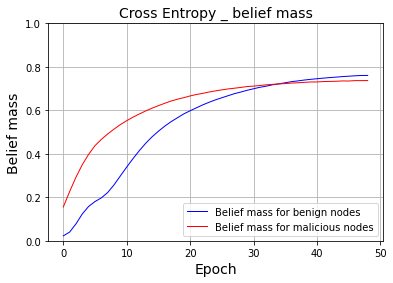

In [32]:
mean_positive_belief_mass=[]
mean_negative_belief_mass=[]
for i in range(0,len(belief_mass_vector)-1):
    mean_positive_belief_mass.append(np.mean(torch.Tensor.cpu(belief_mass_vector[i][:,0][belief_mass_vector[i][:,0] != 0]).detach().numpy()))
    mean_negative_belief_mass.append(np.mean(torch.Tensor.cpu(belief_mass_vector[i][:,1][belief_mass_vector[i][:,1] != 0]).detach().numpy()))
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 
x=np.arange(0, len(mean_positive_belief_mass[0:100]), 1, dtype=int)

#plt.plot(uncertainty_mass_vector_first_iteration, color='red',linewidth=0.1) 
#plt.plot(uncertainty_mass_vector_last_iteration, color='blue',linewidth=0.1)
plt.plot(x,mean_positive_belief_mass[0:100] ,color='blue',linewidth=1, label='Belief mass for benign nodes')
plt.plot(x,mean_negative_belief_mass[0:100] ,color='red',linewidth=1, label='Belief mass for malicious nodes')

#plt.title('Dirichlet _ belief mass', fontsize=14)
plt.title('Cross Entropy _ belief mass', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Belief mass', fontsize=14)
plt.legend(loc="lower right")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
#ax.set_ylim([ymin, ymax])
plt.grid(True)
plt.show()

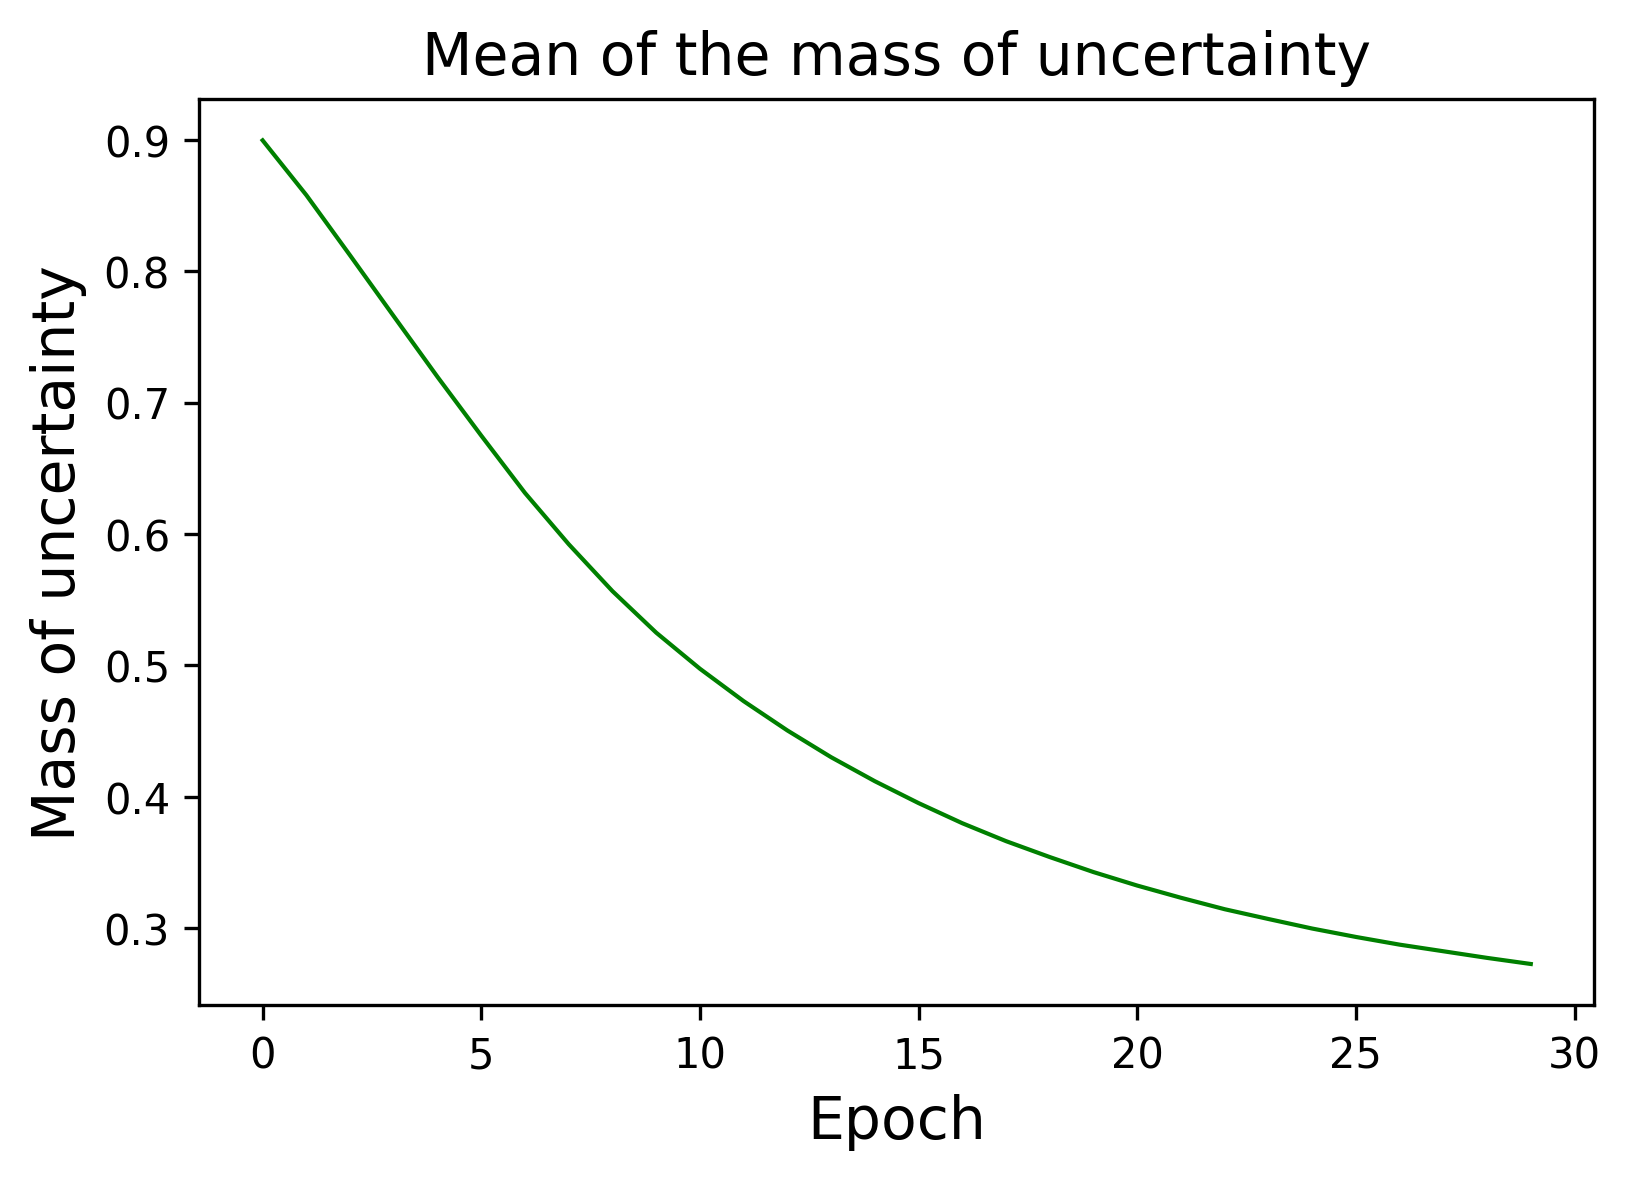

In [33]:
mean_uncertainty_mass=[]
for i in range(0,len(uncertainty_mass_vector)-1):
     mean_uncertainty_mass.append(np.mean(torch.Tensor.cpu(uncertainty_mass_vector[i]).detach().numpy()))
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 
x=np.arange(0, len(mean_uncertainty_mass[0:30]), 1, dtype=int)

#plt.plot(uncertainty_mass_vector_first_iteration, color='red',linewidth=0.1) 
#plt.plot(uncertainty_mass_vector_last_iteration, color='blue',linewidth=0.1)
plt.plot(x,mean_uncertainty_mass[0:30] ,color='green',linewidth=1)

plt.title('Mean of the mass of uncertainty', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mass of uncertainty', fontsize=14)
plt.grid(False)
plt.show()    

In [44]:
Performance = compute_performance(model, train_dataset)    

[TP] 33299	[FP] 39
[TN] 40256	[FN] 218
Precision: 0.9988
Recall: 0.9935
Accuracy: 0.9965
F1 Score: 0.9962


<Figure size 1800x1200 with 0 Axes>

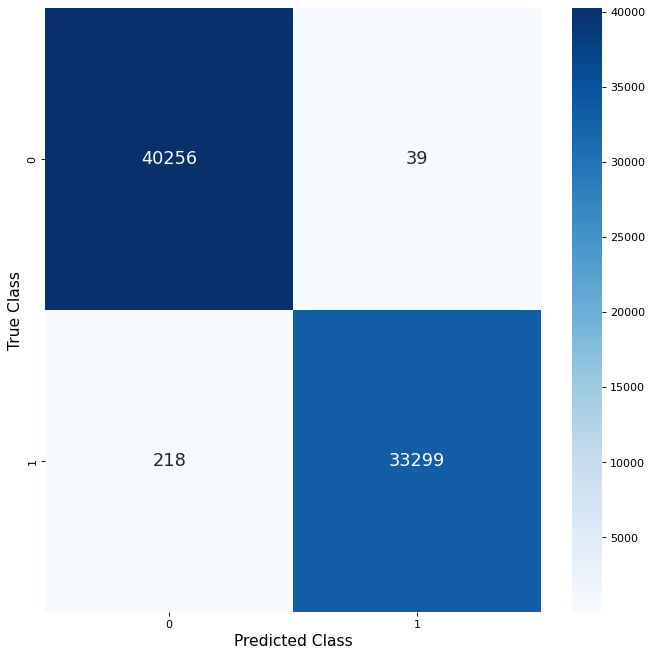

<Figure size 1800x1200 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
conf = [[Performance["tn"],Performance["fp"]],[Performance["fn"],Performance["tp"]]]
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g',cmap="Blues")
print('[TP] {}\t[FP] {}'.format(Performance["tp"], Performance["fp"]))
print('[TN] {}\t[FN] {}'.format(Performance["tn"], Performance["fn"]))  
print('Precision: %.4f' % Performance["Precision"])
print('Recall: %.4f' % Performance["Recall"])
print('Accuracy: %.4f' % Performance["Accuracy"])
print('F1 Score: %.4f' % Performance["F1_Score"])
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.figure()

# GNNExplainer

In [ ]:
from collections import defaultdict

def get_malicious_devices():
    malicious_nodes= set()
    index=0
    for prediction in Performance["total_prediction"].tolist():
        if prediction==1:
            malicious_nodes.add(index) 
        index+=1    
    #set_of_devices= set()  
    set_of_devices = defaultdict(set)
    for node in malicious_nodes:
        set_of_devices[data.iloc[[node]]['IPV4_SRC_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0]].add(node)
        set_of_devices[data.iloc[[node]]['IPV4_DST_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0]].add(node)

        #set_of_devices.add(data.iloc[[node]]['IPV4_DST_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0])   
        #set_of_devices.add(data.iloc[[node]]['IPV4_SRC_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0])
    return set_of_devices

In [ ]:
set_of_devices=get_malicious_devices()

In [ ]:
print("Malicious devices found by model on unlabeled nodes: "+ str(set(set_of_devices.keys())))
print("\nGround truth of malicious devices: "+ str(np.unique([data1["IPV4_SRC_ADDR"], data1["IPV4_DST_ADDR"]])))


In [ ]:
device_target='149.171.126.12'

In [ ]:
node_idx = 131076
x, edge_index = train_dataset.x, train_dataset.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
ax, G = explainer.visualize_subgraph(131076, edge_index, edge_mask, y=train_dataset.y)

plt.show()

In [ ]:
data.iloc[[node_idx]]

In [ ]:
print("Communications analyzed: \n"+str(data.iloc[[node_idx]]))
print("Pediction: "+str(Performance["total_prediction"].tolist()[node_idx]))

In [ ]:
print("The following communications are decisive for classifying the communication analyzed:")
for node in G.nodes:
    print(data.iloc[[node]])
    print("\nuncertainy"+str(Performance["total_uncertainty_mass_vector"][node]))
    print("belief_mass_vector"+str(Performance["total_belief_mass_vector"][node])+str("\n"))
    
print("\n\nThe devices strongly connected to the communication analyzed are the following:")
set_of_devices= set()
for node in G.nodes:
    set_of_devices.add(data.iloc[[node]]['IPV4_DST_ADDR'].apply(lambda x: str(x.split(':')[0])).values[0])

for device in set_of_devices:
    print(str(device))